# Code Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt


from naive_bayes_classifier import NaiveBayes

# Reading the Data

In [2]:
inflammation_data = pd.read_csv('./inflammation_diagnosis.csv', delimiter=';')

# Inspecting the Data

In [3]:
inflammation_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   temperature         120 non-null    float64
 1   nausea              120 non-null    object 
 2   lumbar_pain         120 non-null    object 
 3   urine_pushing       120 non-null    object 
 4   micturition_pains   120 non-null    object 
 5   burning_of_urethra  120 non-null    object 
 6   inflammation        120 non-null    object 
 7   nephritis           120 non-null    object 
dtypes: float64(1), object(7)
memory usage: 7.6+ KB


# Plot the data

plot with seaborn, use different colors and sort the values by colors

In [4]:
import seaborn as sns

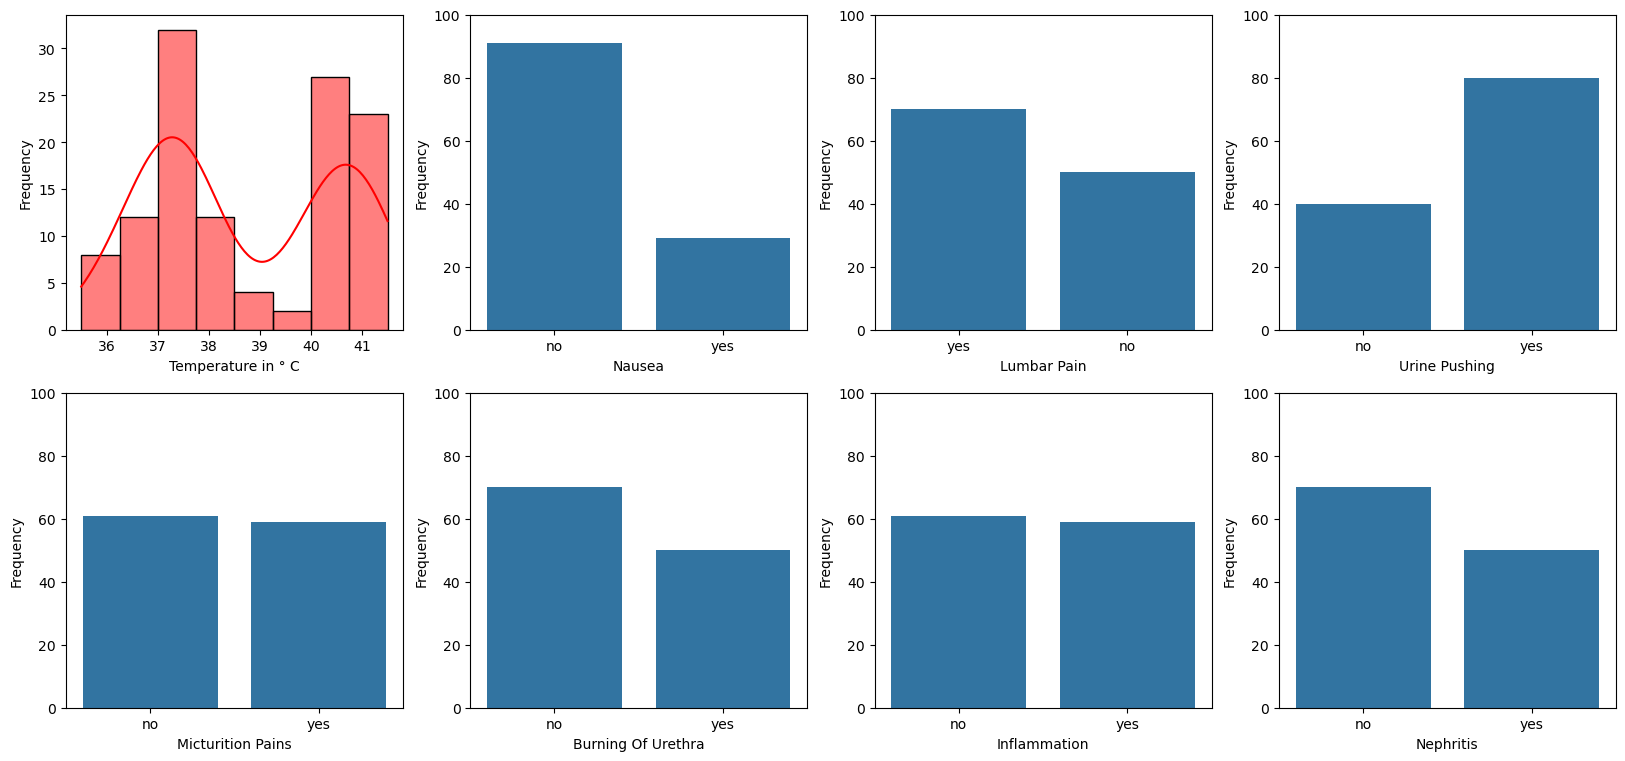

In [5]:
rows = 2
columns = 4
fig,ax = plt.subplots(nrows=rows, ncols=columns, figsize=(20,9))
[""]
index = 0 

for row in range(rows):
    for column in range(columns):
        nice_col_name = inflammation_data.columns.to_list()[index]
        nice_col_name = " ".join(word[0].upper() + word[1:] for word in nice_col_name.split("_"))
        
        
        if inflammation_data.columns[index] == 'temperature':
            s = sns.histplot(inflammation_data, ax=ax[row,column], x=inflammation_data.columns[column], kde=True, color='r')
            s.set(xlabel = 'Temperature in ° C', ylabel = "Frequency")
            
        else:
            b = sns.countplot(inflammation_data, x=inflammation_data.columns[index], ax=ax[row,column])
            b.set(xlabel = nice_col_name, ylabel = 'Frequency')
            b.set_ylim(0,100)
            
        index += 1

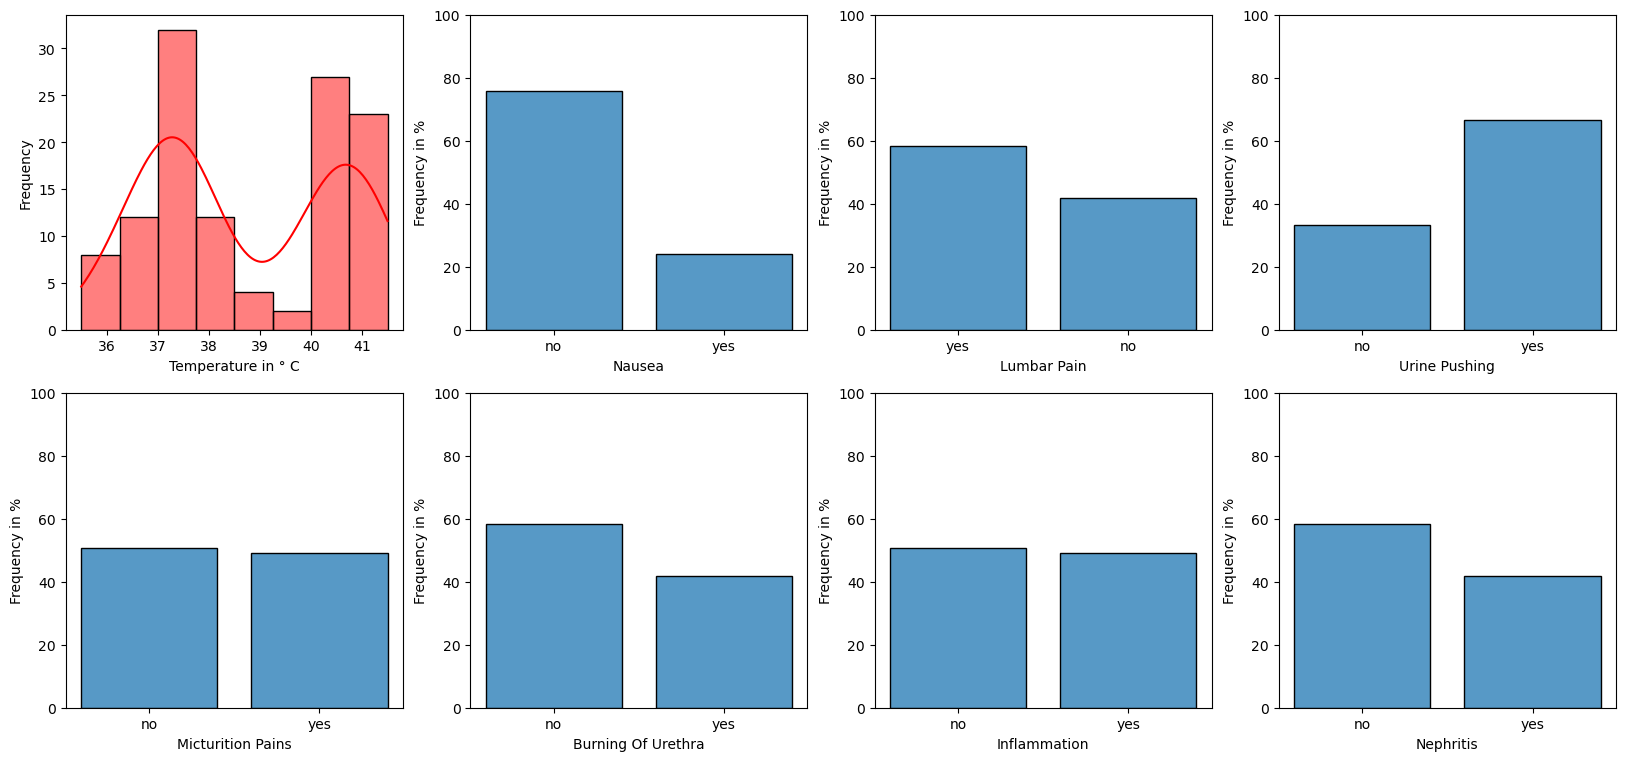

In [6]:
rows = 2
columns = 4
fig,ax = plt.subplots(nrows=rows, ncols=columns, figsize=(20,9))
[""]
index = 0 

for row in range(rows):
    for column in range(columns):
        nice_col_name = inflammation_data.columns.to_list()[index]
        nice_col_name = " ".join(word[0].upper() + word[1:] for word in nice_col_name.split("_"))
        
        
        if inflammation_data.columns[index] == 'temperature':
            s = sns.histplot(inflammation_data, ax=ax[row,column], x=inflammation_data.columns[column], kde=True, color='r')
            s.set(xlabel = 'Temperature in ° C', ylabel = "Frequency")
            
        else:
            b = sns.histplot(inflammation_data, ax=ax[row,column], x=inflammation_data.columns[index], stat='percent', discrete=True, shrink=.8)
            #b = sns.countplot(inflammation_data, x=inflammation_data.columns[index], ax=ax[row,column])
            b.set(xlabel = nice_col_name, ylabel = 'Frequency in %')
            b.set_ylim(0,100)
            
        index += 1

# Creating Labels
## Transforming Nominal Data to Booleans

In [7]:
inflammation_data = inflammation_data.replace(to_replace='no', value=False)
inflammation_data = inflammation_data.replace(to_replace='yes', value=True)

inflammation_data

,temperature,nausea,lumbar_pain,urine_pushing,micturition_pains,burning_of_urethra,inflammation,nephritis
0,35.5,False,True,False,False,False,False,False
1,35.9,False,False,True,True,True,True,False
2,35.9,False,True,False,False,False,False,False
3,36.0,False,False,True,True,True,True,False
4,36.0,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...
115,41.4,False,True,True,False,True,False,True
116,41.5,False,False,False,False,False,False,False
117,41.5,True,True,False,True,False,False,True
118,41.5,False,True,True,False,True,False,True


Checking if the columns are indeed of type boolean

In [8]:
inflammation_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   temperature         120 non-null    float64
 1   nausea              120 non-null    bool   
 2   lumbar_pain         120 non-null    bool   
 3   urine_pushing       120 non-null    bool   
 4   micturition_pains   120 non-null    bool   
 5   burning_of_urethra  120 non-null    bool   
 6   inflammation        120 non-null    bool   
 7   nephritis           120 non-null    bool   
dtypes: bool(7), float64(1)
memory usage: 1.9 KB


## Adding Disease Labels 
Add the disease values to a new label-column and check if the values make sense

In [9]:
inflammation_data['disease'] = [False if (inflammation_data['inflammation'][i] == False) & (inflammation_data['nephritis'][i] == False) else True for i in range(0,len(inflammation_data))]

# Splitting the Data
Count the values of 'disease' to see how the data is distributed

In [10]:
inflammation_data['disease'].value_counts(True)

disease
True     0.75
False    0.25
Name: proportion, dtype: float64

## Calculating Split Indices
The data split must account for the obvious imbalance in the data. Therefore, calculate the indices of the splits.

# Drop duplicates to avoid the same patients for training and test set

<hr>
<h1> Think about when do drop data.....nicht, dass es was an der Wahrscheinlichkeit ändert
<br>
<hr>

In [ ]:
#inflammation_data = inflammation_data.drop_duplicates()

In [ ]:
train = pd.concat([inflammation_data[inflammation_data['disease'] == True].sample(frac =0.8), inflammation_data[inflammation_data['disease'] == False].sample(frac = 0.8)])
test = inflammation_data.drop(train.index)

## Ensuring that the two dataframes do not share a column
The following merge shows duplicate rows across the two dataframes. If empty, there are no duplicates.

In [ ]:
set(list(test.index)).isdisjoint(list(train.index))

# Shows same values for training and test set, this are not the same patiens, just patients with the same values 

In [ ]:
result = train.merge(right=test, how='inner', indicator=False)
result

In [ ]:
train_1 = train
test_1 = test

test_1['original_index'] = range(1, len(test_1) + 1)
train_1['original_index'] = range(1, len(train_1) + 1)

result_1 = train_1.merge(right=test_1, how='inner', indicator=False)
result_1

# TESTING

In [ ]:
test

### Was machen wir, wenn es eine Wahrscheinlichekti nicht gibt ?, die müsste ja dann null sein oder 

In [ ]:
inflammation_data.groupby(["disease", inflammation_data["nausea"]]).size()/  inflammation_data.groupby(["disease"]).size()

# positiv posterior soll grösser sein als negative posterior

evidence noch berechnen mit negative and positive posterior <hr>

In [10]:
t = NaiveBayes()
p,f = t.fit(inflammation_data, "disease")
print(p)
print("''''''''''''''")
f[False]


{'temperature':           False      True 
mean  38.140000  38.918889
std    1.925438   1.750242}
''''''''''''''


,nausea,lumbar_pain,urine_pushing,micturition_pains,burning_of_urethra,inflammation,nephritis
False,1.0,0.333333,1.0,1.0,1.0,1.0,1.0
True,0.0,0.666667,0.0,0.0,0.0,0.0,0.0


In [11]:
f[True]

,nausea,lumbar_pain,urine_pushing,micturition_pains,burning_of_urethra,inflammation,nephritis
False,0.677778,0.444444,0.111111,0.344444,0.444444,0.344444,0.444444
True,0.322222,0.555556,0.888889,0.655556,0.555556,0.655556,0.555556


In [14]:
print(pd.DataFrame.from_dict(f[True])) 

       nausea  lumbar_pain  urine_pushing  micturition_pains  \
False     1.0     0.333333            1.0                1.0   
True      0.0     0.666667            0.0                0.0   

       burning_of_urethra  inflammation  nephritis  disease  
False                 1.0           1.0        1.0      1.0  
True                  0.0           0.0        0.0      0.0  


In [13]:
pd.DataFrame.from_dict(f[True]) 

,nausea,lumbar_pain,urine_pushing,micturition_pains,burning_of_urethra,inflammation,nephritis,disease
False,0.677778,0.444444,0.111111,0.344444,0.444444,0.344444,0.444444,0.0
True,0.322222,0.555556,0.888889,0.655556,0.555556,0.655556,0.555556,1.0


In [ ]:
p["temperature"][False]["mean"]

In [ ]:
f = pd.DataFrame.from_dict(f)

In [ ]:
inflammation_data.groupby(["disease", inflammation_data["nausea"]]).size()/  inflammation_data.groupby(["disease"]).size()

<hr>
<br>

<ul>
<li>wenn ich fertig bin, so programmieren, dass man alle duplicates aus der temperature nimmt und dann nur noch einträgt</li>
<li>maybe auch schönes pd dataframe basteln als v-loook up </li>
<li>wenn temperatur neuer wert ist, dann die zwei closesten wählen und den durchschnitt nehmen</li>
</ul>
<br>
<hr>

In [24]:
c = inflammation_data.groupby(["disease", "nephritis"]).size()/ inflammation_data.groupby(["disease"]).size()
c

  

disease  nephritis
False    False        1.000000
True     False        0.444444
         True         0.555556
dtype: float64

In [11]:
def calculate_continuous(data: pd.DataFrame, column: str, target_name: str, labels: list):
    variable_continuous = {}
    
    for label in labels:
        variables_per_label = {}
        filtered_data = data[data[target_name]==label]
        variables_per_label["mean"] = filtered_data[column].mean()
        variables_per_label["std"] = filtered_data[column].std()
        variable_continuous[label] = variables_per_label
        
    continous_variables = pd.DataFrame.from_dict(variable_continuous)
    
    return continous_variables

In [12]:
def calculate_discrete(target_labels: list, con_prob: pd.Series, current_label: str):

    label_dict = {label: None for label in target_labels}
    print("discrete")
    for label_feature in target_labels:
        try:
            label_dict[label_feature] = con_prob.loc[current_label][label_feature]
        except:
            label_dict[label_feature] = 0.0
    print("done")
    print(label_dict)
    return label_dict

In [18]:
target_name = "disease"
data = inflammation_data[["temperature", "nausea", "disease"]]

gaus_variables = {}
labels = list(data[target_name].unique())
column_dict = {column: {} for column in data.columns.values[1:-1]}

con_discrete = {label: column_dict.copy() for label in labels}    

for column in data.columns[:-1]:
    label_prob = {}
    # calculcate continous
    if data[column].dtypes == float:
            gaus_variables[column] = calculate_continuous(data, column, "disease", labels)
    else:
        for label in labels:
        # calculate discrete
            con_prob = data.groupby([target_name, column]).size()/ data.groupby([target_name]).size()
            con_discrete[label][column] = calculate_discrete(labels, con_prob, label)
        
        print("done_all")
        print(con_discrete)
            





False
nausea
{False: {'nausea': {}}, True: {'nausea': {}}}
discrete
done
{False: 1.0, True: 0.0}
True
nausea
{False: {'nausea': {False: 1.0, True: 0.0}}, True: {'nausea': {}}}
discrete
done
{False: 0.6777777777777778, True: 0.32222222222222224}
done_all
{False: {'nausea': {False: 1.0, True: 0.0}}, True: {'nausea': {False: 0.6777777777777778, True: 0.32222222222222224}}}


In [17]:
labels = [False,True]
label_prob = {}
eda = {False: {'nausea': {False: 0.6777777777777778, True: 0.32222222222222224}}, True: {'nausea': {False: 0.6777777777777778, True: 0.32222222222222224}}}
index = 0
for label in labels:
    for label_2 in labels:
        eda[label]["nausea"][label_2] = index
        index += 1

eda

{False: {'nausea': {False: 0, True: 1}}, True: {'nausea': {False: 2, True: 3}}}

In [ ]:
f

In [ ]:
training_tuples = round((len(inflammation_data)/10)*8)
df_training = inflammation_data.iloc[:training_tuples,:]
df_test = inflammation_data.iloc[training_tuples:,:]
df_test = df_test.reset_index(drop=True)

df_training

In [ ]:
df_test = df_test.drop("disease",axis=1)


In [ ]:
d = {"key": 1.1, "st":2.2}
d.values()

In [ ]:
t = NaiveBayes()
gaus, discrete  = t.fit(df_training, "disease")
result = t.predict_probability(df_test, "disease")
result

In [ ]:
discrete["lumbar_pain"][False]

In [ ]:
sum([0.0,0.0])